[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/03a-token-counter.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/03a-token-counter.ipynb)

#### [LangChain Handbook](https://www.pinecone.io/learn/series/langchain)

# Conversational Memory

## Extra Material: Token Counter

This is an additional piece of material alongside the [LangChain Handbook notebook on Conversational Memory](https://github.com/pinecone-io/examples/blob/master/generation/langchain/handbook/03-langchain-conversational-memory.ipynb).

In this notebook we will count the number of tokens used in a conversation for different conversational memory types.

We begin by installing the required libraries:

In [1]:
!pip install -qU \
  langchain==0.3.25 \
  langchain-community==0.3.25 \
  langchain-openai==0.3.22 \
  transformers==4.52.4 \
  seaborn==0.13.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.9 MB/s eta 0:00:00


To run the notebook we'll use OpenAI's `gpt-4.1-mini` model. We initialize it via LangChain like so:

In [2]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") \
    or getpass("Enter your OpenAI API key: ")

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

Enter your OpenAI API key: ··········


In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    temperature=0,
    openai_api_key=OPENAI_API_KEY,
    model_name='gpt-4.1-mini'
)

To count the number of tokens used during each call we will define a `count_tokens` function:

In [4]:
from langchain.callbacks import get_openai_callback

def count_tokens(chain, query, config=None):
    with get_openai_callback() as cb:
        # Handle both dict and string inputs
        if isinstance(query, str):
            query = {"query": query}

        # Use provided config or default
        if config is None:
            config = {"configurable": {"session_id": "default"}}

        result = chain.invoke(query, config=config)
        print(f'Spent a total of {cb.total_tokens} tokens')

    return {
        'result': result,
        'token_count': cb.total_tokens
    }

## Define System Prompt and LCEL Pipeline

In [5]:
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder
)
from langchain.schema.output_parser import StrOutputParser

# Define the prompt template
system_prompt = """The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know."""

prompt_template = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt),
    MessagesPlaceholder(variable_name="history"),
    HumanMessagePromptTemplate.from_template("{query}"),
])

# Create the LCEL pipeline
output_parser = StrOutputParser()
pipeline = prompt_template | llm | output_parser

## Runnables with Message Histories

Here the Runnable Classes which utilize different types of memory are defined.

### Memory Type #1: Buffer Memory - Store the Entire Chat History

An alternative to `ConversationBufferMemory`. The simplest method, which stores the entire chat history as memory.

In [6]:
from langchain_core.chat_history import InMemoryChatMessageHistory

# Create a simple chat history storage
chat_map = {}

def get_chat_history(session_id: str) -> InMemoryChatMessageHistory:
    if session_id not in chat_map:
        # if session ID doesn't exist, create a new chat history
        chat_map[session_id] = InMemoryChatMessageHistory()
    return chat_map[session_id]

### Memory type #2: Summary - Store Summaries of Past Interactions

This is an LCEL-Comptaible alternative to `ConversationSummaryMemory`. We keep a summary of our previous conversation snippets as our history. The summarization is performed by an LLM.

In [9]:
from langchain_core.messages import BaseMessage, SystemMessage

from langchain_core.chat_history import BaseChatMessageHistory
from pydantic import BaseModel, Field

class ConversationSummaryMessageHistory(BaseChatMessageHistory, BaseModel):
    messages: list[BaseMessage] = Field(default_factory=list)
    llm: ChatOpenAI = Field(default_factory=ChatOpenAI)

    def __init__(self, llm: ChatOpenAI):
        super().__init__(llm=llm)

    def add_messages(self, messages: list[BaseMessage]) -> None:
        """Add messages to the history and update the summary."""
        self.messages.extend(messages)

        # Construct the summary prompt
        summary_prompt = ChatPromptTemplate.from_messages([
            SystemMessagePromptTemplate.from_template(
                "Given the existing conversation summary and the new messages, "
                "generate a new summary of the conversation. Ensure to maintain "
                "as much relevant information as possible."
            ),
            HumanMessagePromptTemplate.from_template(
                "Existing conversation summary:\n{existing_summary}\n\n"
                "New messages:\n{messages}"
            )
        ])

        # Format the messages and invoke the LLM
        new_summary = self.llm.invoke(
            summary_prompt.format_messages(
                existing_summary=self.messages,
                messages=messages
            )
        )

        # Replace the existing history with a single system summary message
        self.messages = [SystemMessage(content=new_summary.content)]

    def clear(self) -> None:
        """Clear the history."""
        self.messages = []

# Create get_summary_chat_history function for summary memory
summary_chat_map = {}

def get_summary_chat_history(session_id: str, llm: ChatOpenAI) -> ConversationSummaryMessageHistory:
    if session_id not in summary_chat_map:
        summary_chat_map[session_id] = ConversationSummaryMessageHistory(llm=llm)
    return summary_chat_map[session_id]

### Memory type #3: Window Buffer Memory - Keep Latest Interactions

An LCEL-compatible alternative to `ConversationBufferWindowMemory`. Window memory where we keep only the last k interactions in our memory and intentionally drop the oldest ones

In [10]:
class BufferWindowMessageHistory(BaseChatMessageHistory, BaseModel):
    messages: list[BaseMessage] = Field(default_factory=list)
    k: int = Field(default_factory=int)

    def __init__(self, k: int):
        super().__init__(k=k)
        # Add logging to help with debugging
        print(f"Initializing BufferWindowMessageHistory with k={k}")

    def add_messages(self, messages: list[BaseMessage]) -> None:
        """Add messages to the history, removing any messages beyond
        the last `k` messages.
        """
        self.messages.extend(messages)
        # Add logging to help with debugging
        if len(self.messages) > self.k:
            print(f"Truncating history from {len(self.messages)} to {self.k} messages")
        self.messages = self.messages[-self.k:]

    def clear(self) -> None:
        """Clear the history."""
        self.messages = []

# Create get_chat_history function for window memory
window_chat_map = {}

def get_window_chat_history(session_id: str, k: int = 4) -> BufferWindowMessageHistory:
    print(f"get_window_chat_history called with session_id={session_id} and k={k}")
    if session_id not in window_chat_map:
        window_chat_map[session_id] = BufferWindowMessageHistory(k=k)
    return window_chat_map[session_id]

### Memory type #4:  Window + Summary Hybrid

An LCEL-compatible alternative to `ConversationSummaryBufferMemory`. Combines the benefits of both summary and buffer window memory.

In [12]:
class ConversationSummaryBufferMessageHistory(BaseChatMessageHistory, BaseModel):
    messages: list[BaseMessage] = Field(default_factory=list)
    llm: ChatOpenAI = Field(default_factory=ChatOpenAI)
    k: int = Field(default_factory=int)

    def __init__(self, llm: ChatOpenAI, k: int):
        super().__init__(llm=llm, k=k)

    def add_messages(self, messages: list[BaseMessage]) -> None:
        """Add messages to the history, removing any messages beyond
        the last `k` messages and summarizing the messages that we drop.
        """
        existing_summary = None
        old_messages = None

        # See if we already have a summary message
        if len(self.messages) > 0 and isinstance(self.messages[0], SystemMessage):
            existing_summary = self.messages.pop(0)

        # Add the new messages to the history
        self.messages.extend(messages)

        # Check if we have too many messages
        if len(self.messages) > self.k:
            # Pull out the oldest messages...
            old_messages = self.messages[:-self.k]
            # ...and keep only the most recent messages
            self.messages = self.messages[-self.k:]

        if old_messages is None:
            # If we have no old_messages, we have nothing to update in summary
            return

        # Construct the summary chat messages
        summary_prompt = ChatPromptTemplate.from_messages([
            SystemMessagePromptTemplate.from_template(
                "Given the existing conversation summary and the new messages, "
                "generate a new summary of the conversation. Ensure to maintain "
                "as much relevant information as possible."
            ),
            HumanMessagePromptTemplate.from_template(
                "Existing conversation summary:\n{existing_summary}\n\n"
                "New messages:\n{old_messages}"
            )
        ])

        # Format the messages and invoke the LLM
        new_summary = self.llm.invoke(
            summary_prompt.format_messages(
                existing_summary=existing_summary or "No previous summary",
                old_messages=old_messages
            )
        )

        # Prepend the new summary to the history
        self.messages = [SystemMessage(content=new_summary.content)] + self.messages

    def clear(self) -> None:
        """Clear the history."""
        self.messages = []

# Create get_chat_history function for summary buffer memory
summary_buffer_chat_map = {}

def get_summary_buffer_chat_history(session_id: str, llm: ChatOpenAI, k: int = 4) -> ConversationSummaryBufferMessageHistory:
    if session_id not in summary_buffer_chat_map:
        summary_buffer_chat_map[session_id] = ConversationSummaryBufferMessageHistory(llm=llm, k=k)
    return summary_buffer_chat_map[session_id]

## Create Conversation Chains and Conversation Function

Create set of conversation chains that we'll be using:

In [13]:
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.runnables import ConfigurableFieldSpec

# First, create separate history factory functions for each k value
def get_window_chat_history_k6(session_id: str, k: int = 6):
    return BufferWindowMessageHistory(k=k)  # Changed from WindowChatHistory

def get_window_chat_history_k12(session_id: str, k: int = 12):
    return BufferWindowMessageHistory(k=k)  # Changed from WindowChatHistory

def get_summary_buffer_chat_history_k6(session_id: str, llm: ChatOpenAI, k: int = 6):
    return ConversationSummaryBufferMessageHistory(llm=llm, k=k)  # Changed from SummaryBufferChatHistory

def get_summary_buffer_chat_history_k12(session_id: str, llm: ChatOpenAI, k: int = 12):
    return ConversationSummaryBufferMessageHistory(llm=llm, k=k)  # Changed from SummaryBufferChatHistory

# Then update the conversation_chains dictionary to use these specific functions
conversation_chains = {
    'RunnableWithMessageHistory': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_chat_history,
        input_messages_key="query",
        history_messages_key="history"
    ),
    'ConversationSummaryMessageHistory': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_summary_chat_history,
        input_messages_key="query",
        history_messages_key="history",
        history_factory_config=[
            ConfigurableFieldSpec(
                id="session_id",
                annotation=str,
                name="Session ID",
                description="The session ID to use for the chat history",
                default="summary_history",
            ),
            ConfigurableFieldSpec(
                id="llm",
                annotation=ChatOpenAI,
                name="LLM",
                description="The LLM to use for the conversation summary",
                default=llm,
            )
        ]
    ),
    'BufferWindowMessageHistory(k=6)': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_window_chat_history_k6,  # Changed to k6 specific function
        input_messages_key="query",
        history_messages_key="history",
        history_factory_config=[
            ConfigurableFieldSpec(
                id="session_id",
                annotation=str,
                name="Session ID",
                description="The session ID to use for the chat history",
                default="window_history_k6",
            ),
            ConfigurableFieldSpec(
                id="k",
                annotation=int,
                name="k",
                description="The number of messages to keep in the history",
                default=6,
            )
        ]
    ),
    'BufferWindowMessageHistory(k=12)': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_window_chat_history_k12,  # Changed to k12 specific function
        input_messages_key="query",
        history_messages_key="history",
        history_factory_config=[
            ConfigurableFieldSpec(
                id="session_id",
                annotation=str,
                name="Session ID",
                description="The session ID to use for the chat history",
                default="window_history_k12",
            ),
            ConfigurableFieldSpec(
                id="k",
                annotation=int,
                name="k",
                description="The number of messages to keep in the history",
                default=12,
            )
        ]
    ),
    'ConversationSummaryBufferMessageHistory(k=6)': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_summary_buffer_chat_history_k6,  # Changed to k6 specific function
        input_messages_key="query",
        history_messages_key="history",
        history_factory_config=[
            ConfigurableFieldSpec(
                id="session_id",
                annotation=str,
                name="Session ID",
                description="The session ID to use for the chat history",
                default="summary_buffer_k6",
            ),
            ConfigurableFieldSpec(
                id="llm",
                annotation=ChatOpenAI,
                name="LLM",
                description="The LLM to use for the conversation summary",
                default=llm,
            ),
            ConfigurableFieldSpec(
                id="k",
                annotation=int,
                name="k",
                description="The number of messages to keep in the history",
                default=6,
            )
        ]
    ),
    'ConversationSummaryBufferMessageHistory(k=12)': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_summary_buffer_chat_history_k12,  # Changed to k12 specific function
        input_messages_key="query",
        history_messages_key="history",
        history_factory_config=[
            ConfigurableFieldSpec(
                id="session_id",
                annotation=str,
                name="Session ID",
                description="The session ID to use for the chat history",
                default="summary_buffer_k12",
            ),
            ConfigurableFieldSpec(
                id="llm",
                annotation=ChatOpenAI,
                name="LLM",
                description="The LLM to use for the conversation summary",
                default=llm,
            ),
            ConfigurableFieldSpec(
                id="k",
                annotation=int,
                name="k",
                description="The number of messages to keep in the history",
                default=12,
            )
        ]
    )
}

Let's define the conversation function:

In [16]:
from tqdm.auto import tqdm
import openai

queries = [
    "Good morning AI?",
    """My interest here is to explore the potential of integrating Large
    Language Models with external knowledge""",
    "I just want to analyze the different possibilities. What can you think of?",
    "What about the use of retrieval augmentation, can that be used as well?",
    """That's very interesting, can you tell me more about this? Like what
    systems would I use to store the information and retrieve relevant info?""",
    """Okay that's cool, I've been hearing about 'vector databases', are they
    relevant in this context?""",
    """Okay that's useful, but how do I go from my external knowledge to
    creating these 'vectors'? I have no idea how text can become a vector?""",
    """Well I don't think I'd be using word embeddings right? If I wanted to
    store my documents in this vector database, I suppose I would need to
    transform the documents into vectors? Maybe I can use the 'sentence
    embeddings' for this, what do you think?""",
    """Can sentence embeddings only represent sentences of text? That seems
    kind of small to capture any meaning from a document? Is there any approach
    that can encode at least a paragraph of text?""",
    """Huh, interesting. I do remember reading something about 'mpnet' or
    'minilm' sentence 'transformer' models that could encode small to
    medium sized paragraphs. Am I wrong about this?""",
    """Ah that's great to hear, do you happen to know how much text I can feed
    into these types of models?""",
    """I've never heard of hierarchical embeddings, could you explain those in
    more detail?""",
    """So is it like you have a transformer model or something else that creates
    sentence level embeddings, then you feed all of the sentence level
    embeddings into another separate neural network that knows how to merge
    multiple sentence embeddings into a single embedding?""",
    """Could you explain this process step by step from start to finish? Explain
    like I'm very new to this space, assume I don't have much prior knowledge
    of embeddings, neural nets, etc""",
    """Awesome thanks! Are there any popular 'heirarchical neural network'
    models that I can look up? Or maybe just the second stage that creates the
    hierarchical embeddings?""",
    "It seems like these HAN models are quite old, is there anything more recent?",
    "Can you explain the difference between transformer-XL and longformer?",
    "How much text can be encoded by each of these models?",
    """Okay very interesting, so before returning to earlier in the conversation.
    I understand now that there are a lot of different transformer (and not
    transformer) based models for creating the embeddings from vectors. Is that
    correct?""",
    """Perfect, so I understand text can be encoded into these embeddings. But
    what then? Once I have my embeddings what do I do?""",
    """I'd like to use these embeddings to help a chatbot or a question-answering
    system answer questions with help from this external knowledge base. I
    suppose this would come under information retrieval? Could you explain that
    process in a little more detail?""",
    """Okay great, that sounds like what I'm hoping to do. When you say the
    'chatbot or question-answering system generates an embedding', what do you
    mean exactly?""",
    """Ah okay, I understand, so it isn't the 'chatbot' model specifically
    creating the embedding right? That's how I understood your earlier comment.
    It seems more like there is a separate embedding model? And that encodes
    the query, then we retrieve the set of relevant documents from the
    external knowledge base? How is that information then used by the chatbot
    or question-answering system exactly?""",
    """Okay but how is the information provided to the chatbot or
    question-answering system?""",
    """So the retrieved information is given to the chatbot / QA system as plain
    text? But then how do we pass in the original query? How can the system
    distinguish between a user's query and all of this additional information?""",
    """That doesn't seem correct to me, my question is — if we are giving the
    chatbot / QA system the user's query AND retrieved information from an
    external knowledge base, and it's all fed into the model as plain text,
    how does the model know what part of the plain text is a query vs. retrieved
    information?""",
    """Yes I get that, but in the text passed to the model, how do we identify
    user prompt vs retrieved information?"""

]

def talk(conversation_chain):
    tokens_used = []
    # we loop through the conversation above, counting token usage as we go
    for user_query in tqdm(queries):
        try:
            # Get the history factory function name
            history_factory = conversation_chain.get_session_history.__name__

            # Create appropriate config based on history factory type
            if history_factory == "get_summary_chat_history":
                config = {"configurable": {"session_id": "summary_history", "llm": llm}}
            elif history_factory in ["get_window_chat_history_k6", "get_window_chat_history_k12"]:
                k = 6 if "k6" in history_factory else 12
                config = {"configurable": {"session_id": f"window_history_k{k}", "k": k}}
            elif history_factory in ["get_summary_buffer_chat_history_k6", "get_summary_buffer_chat_history_k12"]:
                k = 6 if "k6" in history_factory else 12
                config = {"configurable": {"session_id": f"summary_buffer_k{k}", "llm": llm, "k": k}}
            else:
                config = {"configurable": {"session_id": "basic_history"}}

            res = count_tokens(
                conversation_chain,
                user_query,
                config=config
            )
            tokens_used.append(res['token_count'])
        except (openai.APIError, openai.APIConnectionError, openai.RateLimitError, openai.APIStatusError) as e:
            # we hit the token limit of the model or another API error, so break
            print(f"Hit error: {e}")
            break
    return tokens_used

## Run

In [17]:
counts = {}
# loop through each of our memory types above
for key, chain in conversation_chains.items():
    print(key)
    counts[key] = talk(chain)

RunnableWithMessageHistory


  0%|          | 0/27 [00:00<?, ?it/s]

Spent a total of 74 tokens
Spent a total of 629 tokens
Spent a total of 1671 tokens
Spent a total of 2429 tokens
Spent a total of 3476 tokens
Spent a total of 4186 tokens
Spent a total of 5057 tokens
Spent a total of 5765 tokens
Spent a total of 6460 tokens
Spent a total of 7142 tokens
Spent a total of 7726 tokens
Spent a total of 8516 tokens
Spent a total of 9216 tokens
Spent a total of 10228 tokens
Spent a total of 11128 tokens
Spent a total of 12060 tokens
Spent a total of 13096 tokens
Spent a total of 13743 tokens
Spent a total of 14353 tokens
Spent a total of 15006 tokens
Spent a total of 15892 tokens
Spent a total of 16559 tokens
Spent a total of 17330 tokens
Spent a total of 18028 tokens
Spent a total of 18610 tokens
Spent a total of 19295 tokens
Spent a total of 19813 tokens
ConversationSummaryMessageHistory


  0%|          | 0/27 [00:00<?, ?it/s]

Spent a total of 225 tokens
Spent a total of 1643 tokens
Spent a total of 3250 tokens
Spent a total of 3180 tokens
Spent a total of 4582 tokens
Spent a total of 3566 tokens
Spent a total of 3500 tokens
Spent a total of 2455 tokens
Spent a total of 2196 tokens
Spent a total of 1950 tokens
Spent a total of 1338 tokens
Spent a total of 2458 tokens
Spent a total of 2732 tokens
Spent a total of 4310 tokens
Spent a total of 4180 tokens
Spent a total of 4127 tokens
Spent a total of 4190 tokens
Spent a total of 2490 tokens
Spent a total of 3024 tokens
Spent a total of 4575 tokens
Spent a total of 4727 tokens
Spent a total of 3096 tokens
Spent a total of 2633 tokens
Spent a total of 2523 tokens
Spent a total of 2492 tokens
Spent a total of 2615 tokens
Spent a total of 2336 tokens
BufferWindowMessageHistory(k=6)


  0%|          | 0/27 [00:00<?, ?it/s]

Initializing BufferWindowMessageHistory with k=6
Spent a total of 74 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 511 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 147 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 468 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 601 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 542 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 888 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 310 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 599 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 401 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 320 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 691 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 527 tokens


  0%|          | 0/27 [00:00<?, ?it/s]

Initializing BufferWindowMessageHistory with k=12
Spent a total of 74 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 461 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 148 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 506 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 717 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 548 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 952 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 501 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 582 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 403 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 303 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 586 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total o

  0%|          | 0/27 [00:00<?, ?it/s]

Spent a total of 74 tokens
Spent a total of 565 tokens
Spent a total of 188 tokens
Spent a total of 431 tokens
Spent a total of 623 tokens
Spent a total of 508 tokens
Spent a total of 798 tokens
Spent a total of 362 tokens
Spent a total of 594 tokens
Spent a total of 435 tokens
Spent a total of 309 tokens
Spent a total of 651 tokens
Spent a total of 627 tokens
Spent a total of 950 tokens
Spent a total of 751 tokens
Spent a total of 398 tokens
Spent a total of 750 tokens
Spent a total of 122 tokens
Spent a total of 613 tokens
Spent a total of 560 tokens
Spent a total of 677 tokens
Spent a total of 473 tokens
Spent a total of 526 tokens
Spent a total of 461 tokens
Spent a total of 557 tokens
Spent a total of 534 tokens
Spent a total of 646 tokens
ConversationSummaryBufferMessageHistory(k=12)


  0%|          | 0/27 [00:00<?, ?it/s]

Spent a total of 74 tokens
Spent a total of 488 tokens
Spent a total of 276 tokens
Spent a total of 550 tokens
Spent a total of 732 tokens
Spent a total of 503 tokens
Spent a total of 1008 tokens
Spent a total of 305 tokens
Spent a total of 579 tokens
Spent a total of 408 tokens
Spent a total of 319 tokens
Spent a total of 640 tokens
Spent a total of 591 tokens
Spent a total of 790 tokens
Spent a total of 736 tokens
Spent a total of 467 tokens
Spent a total of 721 tokens
Spent a total of 129 tokens
Spent a total of 598 tokens
Spent a total of 498 tokens
Spent a total of 651 tokens
Spent a total of 477 tokens
Spent a total of 493 tokens
Spent a total of 481 tokens
Spent a total of 511 tokens
Spent a total of 531 tokens
Spent a total of 590 tokens


## Plot Token Usage for Various Memory Setups

Here we can see relative token usage of different memory types.

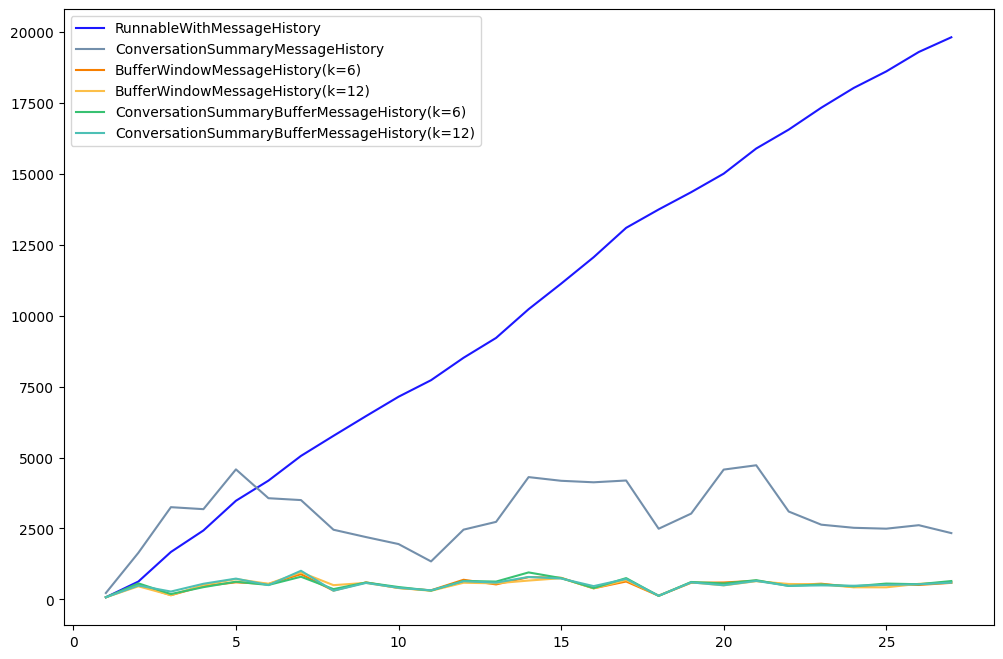

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
max_tokens = 4096

colors = ["#1c17ff", "#738FAB", "#f77f00", "#fcbf49", "#38c172", "#4dc0b5"]

for i, (key, count) in enumerate(counts.items()):
    color = colors[i]
    sns.lineplot(
        x=range(1, len(count)+1),
        y=count,
        label=key,
        color=color
    )
    if max_tokens in count:
        plt.plot(
            len(count), max_tokens, marker="X", color="red", markersize=10
        )

plt.show()

Or, alternatively, a logarithmic plot to show the non `RunnableWithMessageHistory` (blue line) plots more clearly.

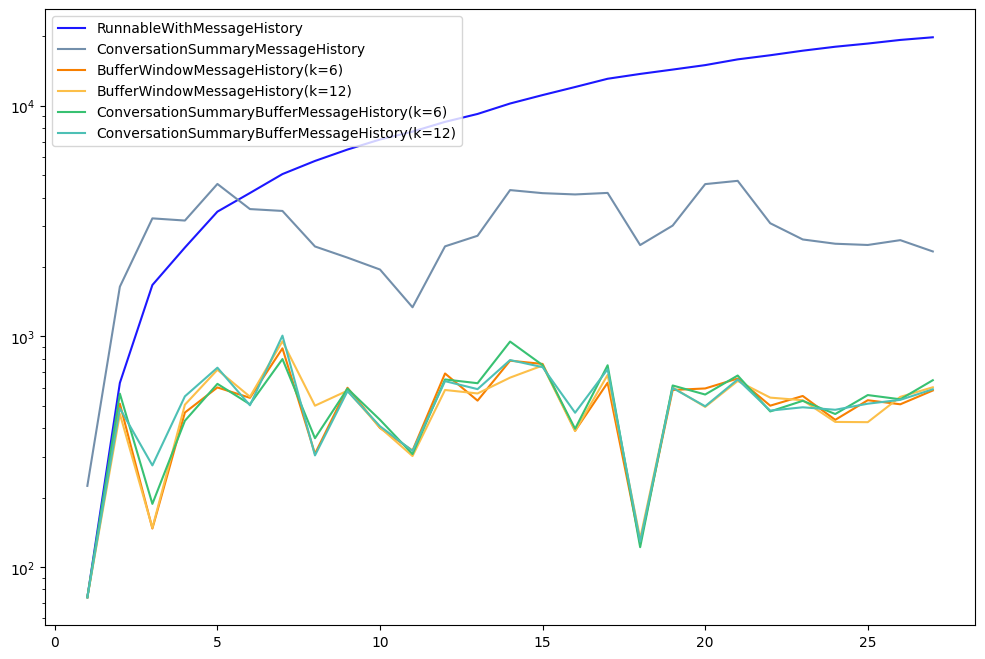

In [21]:
plt.figure(figsize=(12,8))
max_tokens = 4096

colors = ["#1c17ff", "#738FAB", "#f77f00", "#fcbf49", "#38c172", "#4dc0b5"]

for i, (key, count) in enumerate(counts.items()):
    color = colors[i]
    sns.lineplot(
        x=range(1, len(count)+1),
        y=count,
        label=key,
        color=color
    )
    if max_tokens in count:
        plt.plot(
            len(count), max_tokens, marker="X", color="red", markersize=10
        )

plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

---